In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes_masked

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-19 12:24:52.346377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1892] Ignoring visible gpu device (device: 0, name: Quadro K2000, pci bus id: 0000:05:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


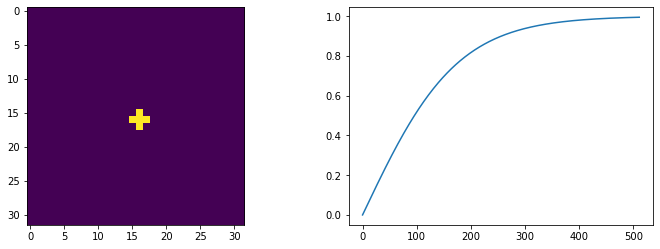

In [4]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

mask = np.zeros_like(data[0, : , :, :], dtype=np.float64)
x_center = x_size//2
y_center = y_size//2


x_mask_domain = np.arange(0, x_size, 1, dtype=np.int32)
y_mask_domain = np.arange(0, x_size, 1, dtype=np.int32)

X_mask, Y_mask = np.meshgrid(x_mask_domain, y_mask_domain, sparse=False, indexing="ij")
radius = np.sqrt( (X_mask-x_center)**2 + (Y_mask-y_center)**2 )
# normalised
radius = radius/np.sqrt( x_center**2 + y_center**2 )


time_scale = 0.06/T
rs = np.zeros_like(t_star)
for i, t in enumerate(t_star):
    r = 2.0/(1+np.exp(-time_scale*t))-1.0
    rs[i] = r
    mask[:, :, i] = radius < r

    
_ = plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(mask[:, :, 10])
plt.subplot(122)
plt.plot(rs)

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

# This is for experimental case only
# In real data, we do not need that
data_masked = data.copy()
data_masked = data*mask

dataset = create_dataset_mask(data_masked, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']
obs_mask = dataset['obs_mask']

In [3]:
layers = [3, 64, 64, 64, 64, 2]
pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = ASDM(dtype=tf.float64, D_a=.005, D_s = 0.2)
model = TINN_masked(pinn, 
                pde_loss, 
                alpha = 0.5, 
                print_precision=".8f")

In [4]:
results = model.train(epochs = 10,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 7.13364363
total loss: 33.55969316, total regularisd loss (sum of batches): 34365.12579155
obs u loss: 0.88340313, obs v loss: 13.38388395
pde u loss: 0.73076747, pde v loss: 18.56163861
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
sigma_a: 10.01415 sigma_s: 9.16084 mu_a: 9.89125 rho_a: 10.48434 
rho_s: 11.06598 kappa_a: 8.90321 
Time taken: 51.78s

Start of epoch 1
Training observations acc over epoch: 5.86521053
total loss: 19.98216768, total regularisd loss (sum of batches): 20461.73970599
obs u loss: 0.95459346, obs v loss: 10.77582753
pde u loss: 0.00314098, pde v loss: 8.24860572
lambda obs u: 0.57443445, lambda obs v: 1.74872025
lambda pde u: 0.50000292, lambda pde v: 1.17684238
sigma_a: 10.03451 sigma_s: 8.35101 mu_a: 9.81554 rho_a: 10.76080 
rho_s: 11.91116 kappa_a: 7.95706 
Time taken: 35.03s

Start of epoch 2
Training observations acc over epoch: 3.16033959
total 

In [3]:
layers = [3, 64, 64, 64, 64, 2]
pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = ASDM(dtype=tf.float64, D_a=.005, D_s = 0.2)
model = TINN_multi_nodes_masked(pinn, 
                pde_loss, 
                alpha = 0.5, 
                print_precision=".8f")

In [4]:
results = model.train(epochs = 5,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 6.67372704
total loss: 29.53606110, total regularisd loss (sum of batches): 30244.92656401
obs node_1 loss: 0.69759019, pde node_1 loss: 0.75091334
obs node_2 loss: 12.64984727, pde node_2 loss: 15.43771030
lambda obs node_1: 1.00000000, lambda pde node_1: 1.00000000
lambda obs node_2: 1.00000000, lambda pde node_2: 1.00000000
sigma_a: 10.01063 sigma_s: 9.17015 mu_a: 9.77556 rho_a: 10.62669 
rho_s: 11.03187 kappa_a: 8.93012 
Time taken: 44.10s

Start of epoch 1
Training observations acc over epoch: 5.01639175
total loss: 16.15412273, total regularisd loss (sum of batches): 16541.82167812
obs node_1 loss: 0.63963686, pde node_1 loss: 0.02204051
obs node_2 loss: 9.39315026, pde node_2 loss: 6.09929511
lambda obs node_1: 0.53398542, lambda pde node_1: 0.50005538
lambda obs node_2: 1.91088067, lambda pde node_2: 1.05507853
sigma_a: 10.03328 sigma_s: 8.38938 mu_a: 9.60290 rho_a: 10.93777 
rho_s: 11.85373 kappa_a: 8.00867 
Time taken: 3

In [11]:
a = 1
to_str = lambda v: f"{v=}".split("=")[0]

def test(param):
    print(to_str(param))
    

In [12]:
to_str(a)

'v'

# Load data

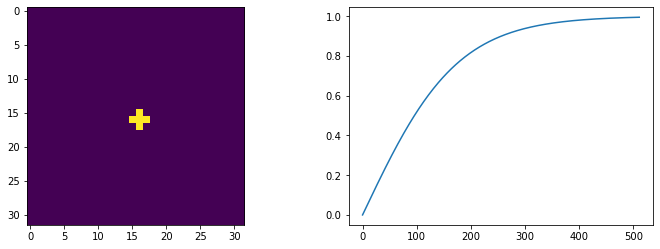

In [3]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

mask = np.zeros_like(data[0, : , :, :], dtype=np.float64)
x_center = x_size//2
y_center = y_size//2


x_mask_domain = np.arange(0, x_size, 1, dtype=np.int32)
y_mask_domain = np.arange(0, x_size, 1, dtype=np.int32)

X_mask, Y_mask = np.meshgrid(x_mask_domain, y_mask_domain, sparse=False, indexing="ij")
radius = np.sqrt( (X_mask-x_center)**2 + (Y_mask-y_center)**2 )
# normalised
radius = radius/np.sqrt( x_center**2 + y_center**2 )


time_scale = 0.06/T
rs = np.zeros_like(t_star)
for i, t in enumerate(t_star):
    r = 2.0/(1+np.exp(-time_scale*t))-1.0
    rs[i] = r
    mask[:, :, i] = radius < r

    
_ = plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(mask[:, :, 10])
plt.subplot(122)
plt.plot(rs)

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

data_masked = data.copy()
data_masked = data*mask

dataset = create_dataset_mask(data_masked, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']
obs_mask = dataset['obs_mask']

In [3]:
layers = [3, 64, 64, 64, 64, 2]
pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = ASDM(dtype=tf.float64, D_a=.005, D_s = 0.2)
model = TINN_masked(pinn, 
                pde_loss, 
                alpha = 0.5, 
                print_precision=".8f")
    

In [4]:
#tf.executing_eagerly()
results = model.train(epochs = 10,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 9.22934151
total loss: 38.05426425, total regularisd loss (sum of batches): 38967.56658776
obs u loss: 0.97421618, obs v loss: 17.48447303
pde u loss: 0.91837415, pde v loss: 18.67720088
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
sigma_a: 10.01530 sigma_s: 9.16810 mu_a: 9.84269 rho_a: 10.55790 
rho_s: 11.02697 kappa_a: 8.93306 
Time taken: 84.22s

Start of epoch 1
Training observations acc over epoch: 7.17306042
total loss: 22.37639210, total regularisd loss (sum of batches): 22913.42550840
obs u loss: 1.04608826, obs v loss: 13.30003240
pde u loss: 0.00196993, pde v loss: 8.02830151
lambda obs u: 0.57292993, lambda obs v: 1.94201506
lambda pde u: 0.50000136, lambda pde v: 0.98505365
sigma_a: 10.03588 sigma_s: 8.36640 mu_a: 9.74185 rho_a: 10.84387 
rho_s: 11.84900 kappa_a: 8.01256 
Time taken: 55.79s

Start of epoch 2
Training observations acc over epoch: 3.13858891
total 

In [14]:
results2 = model.train(epochs = 50,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.27404973
total loss: 1.13050163, total regularisd loss (sum of batches): 1248.92190438
obs u loss: 0.33640498, obs v loss: 0.21169487
pde u loss: 0.26462787, pde v loss: 0.31777392
lambda obs u: 2.69598056, lambda obs v: 0.91015133
lambda pde u: 0.09645792, lambda pde v: 0.29741019
sigma_a: 7.42317 sigma_s: 3.58759 mu_a: 11.67050 rho_a: 9.79603 
rho_s: 15.53877 kappa_a: 3.31768 
Time taken: 43.72s

Start of epoch 1
Training observations acc over epoch: 0.26590225
total loss: 1.10743705, total regularisd loss (sum of batches): 1224.12532763
obs u loss: 0.33212823, obs v loss: 0.19967651
pde u loss: 0.26330187, pde v loss: 0.31233044
lambda obs u: 2.80544232, lambda obs v: 0.78964366
lambda pde u: 0.11997449, lambda pde v: 0.28493953
sigma_a: 7.05932 sigma_s: 3.32103 mu_a: 11.42319 rho_a: 10.44014 
rho_s: 15.53447 kappa_a: 3.35410 
Time taken: 43.77s

Start of epoch 2
Training observations acc over epoch: 0.25997910
total loss: 1.

Training observations acc over epoch: 0.05947788
total loss: 0.19305910, total regularisd loss (sum of batches): 197.22494736
obs u loss: 0.04838677, obs v loss: 0.07056891
pde u loss: 0.06091642, pde v loss: 0.01318700
lambda obs u: 2.42697031, lambda obs v: 0.78568257
lambda pde u: 0.58695772, lambda pde v: 0.20038941
sigma_a: 0.00000 sigma_s: 0.18488 mu_a: 1.24096 rho_a: 19.05915 
rho_s: 3.06888 kappa_a: 14.22514 
Time taken: 43.85s

Start of epoch 19
Training observations acc over epoch: 0.02349791
total loss: 0.13218323, total regularisd loss (sum of batches): 114.46529108
obs u loss: 0.01614906, obs v loss: 0.03084671
pde u loss: 0.08092445, pde v loss: 0.00426301
lambda obs u: 1.37861000, lambda obs v: 0.83806816
lambda pde u: 1.65233333, lambda pde v: 0.13098851
sigma_a: 0.00000 sigma_s: 0.15246 mu_a: 0.99630 rho_a: 17.27496 
rho_s: 2.54801 kappa_a: 15.79646 
Time taken: 43.62s

Start of epoch 20
Training observations acc over epoch: 0.03312372
total loss: 0.10541039, total reg

Training observations acc over epoch: 0.00093058
total loss: 0.00256753, total regularisd loss (sum of batches): 3.02126811
obs u loss: 0.00150237, obs v loss: 0.00035880
pde u loss: 0.00054387, pde v loss: 0.00016249
lambda obs u: 1.20840007, lambda obs v: 0.27152267
lambda pde u: 1.89407308, lambda pde v: 0.62600418
sigma_a: 0.00000 sigma_s: 0.02075 mu_a: 0.03750 rho_a: 1.19611 
rho_s: 0.54991 kappa_a: 28.73682 
Time taken: 44.14s

Start of epoch 37
Training observations acc over epoch: 0.00082102
total loss: 0.00202872, total regularisd loss (sum of batches): 2.29567397
obs u loss: 0.00135435, obs v loss: 0.00028769
pde u loss: 0.00022483, pde v loss: 0.00016185
lambda obs u: 1.50821939, lambda obs v: 0.26221040
lambda pde u: 1.22382845, lambda pde v: 1.00574176
sigma_a: 0.00000 sigma_s: 0.01994 mu_a: 0.02133 rho_a: 0.70925 
rho_s: 0.53173 kappa_a: 28.89793 
Time taken: 43.81s

Start of epoch 38
Training observations acc over epoch: 0.00077553
total loss: 0.00178917, total regularis

In [64]:
results3 = model.train(epochs = 50,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.00041327
total loss: 0.00094818, total regularisd loss (sum of batches): 1.20918328
obs u loss: 0.00060256, obs v loss: 0.00022397
pde u loss: 0.00000164, pde v loss: 0.00012000
lambda obs u: 1.36769548, lambda obs v: 0.39489431
lambda pde u: 0.00181629, lambda pde v: 2.23559392
sigma_a: 0.00020 sigma_s: 0.02404 mu_a: 0.00000 rho_a: 0.00000 
rho_s: 0.52283 kappa_a: 23.88947 
Time taken: 44.28s

Start of epoch 1
Training observations acc over epoch: 0.00039836
total loss: 0.00091667, total regularisd loss (sum of batches): 1.16762751
obs u loss: 0.00057686, obs v loss: 0.00021987
pde u loss: 0.00000164, pde v loss: 0.00011830
lambda obs u: 1.34102477, lambda obs v: 0.39824588
lambda pde u: 0.00170751, lambda pde v: 2.25902184
sigma_a: 0.00019 sigma_s: 0.02499 mu_a: 0.00000 rho_a: 0.00000 
rho_s: 0.52198 kappa_a: 23.14650 
Time taken: 43.82s

Start of epoch 2
Training observations acc over epoch: 0.00039203
total loss: 0.00090209,

Training observations acc over epoch: 0.00026310
total loss: 0.00061303, total regularisd loss (sum of batches): 0.70178938
obs u loss: 0.00036208, obs v loss: 0.00016411
pde u loss: 0.00000167, pde v loss: 0.00008516
lambda obs u: 1.11763377, lambda obs v: 0.42253596
lambda pde u: 0.00248532, lambda pde v: 2.45734495
sigma_a: 0.00031 sigma_s: 0.03064 mu_a: 0.00000 rho_a: 0.00009 
rho_s: 0.33610 kappa_a: 10.86943 
Time taken: 43.70s

Start of epoch 19
Training observations acc over epoch: 0.00025870
total loss: 0.00060283, total regularisd loss (sum of batches): 0.68870389
obs u loss: 0.00035694, obs v loss: 0.00016047
pde u loss: 0.00000166, pde v loss: 0.00008376
lambda obs u: 1.10107893, lambda obs v: 0.40921542
lambda pde u: 0.00253680, lambda pde v: 2.48716886
sigma_a: 0.00022 sigma_s: 0.03063 mu_a: 0.00000 rho_a: 0.00004 
rho_s: 0.31483 kappa_a: 10.16537 
Time taken: 43.64s

Start of epoch 20
Training observations acc over epoch: 0.00024978
total loss: 0.00058249, total regularis

Training observations acc over epoch: 0.00017291
total loss: 0.00039642, total regularisd loss (sum of batches): 0.50846411
obs u loss: 0.00025286, obs v loss: 0.00009295
pde u loss: 0.00000095, pde v loss: 0.00004965
lambda obs u: 1.42094951, lambda obs v: 0.36779785
lambda pde u: 0.00329485, lambda pde v: 2.20795779
sigma_a: 0.00000 sigma_s: 0.01730 mu_a: 0.00926 rho_a: 0.01199 
rho_s: 0.02087 kappa_a: 0.46743 
Time taken: 44.34s

Start of epoch 38
Training observations acc over epoch: 0.00016571
total loss: 0.00038193, total regularisd loss (sum of batches): 0.49665725
obs u loss: 0.00024066, obs v loss: 0.00009076
pde u loss: 0.00000083, pde v loss: 0.00004967
lambda obs u: 1.43792594, lambda obs v: 0.36282345
lambda pde u: 0.00278833, lambda pde v: 2.19646228
sigma_a: 0.00000 sigma_s: 0.01618 mu_a: 0.00997 rho_a: 0.01209 
rho_s: 0.02073 kappa_a: 0.42498 
Time taken: 44.64s

Start of epoch 39
Training observations acc over epoch: 0.00017426
total loss: 0.00039872, total regularisd 

In [79]:
results4 = model.train(epochs = 40,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.00014675
total loss: 0.00034127, total regularisd loss (sum of batches): 0.42854193
obs u loss: 0.00020872, obs v loss: 0.00008479
pde u loss: 0.00000066, pde v loss: 0.00004710
lambda obs u: 1.33928470, lambda obs v: 0.36371928
lambda pde u: 0.00136122, lambda pde v: 2.29563480
sigma_a: 0.00038 sigma_s: 0.01635 mu_a: 0.01153 rho_a: 0.01242 
rho_s: 0.01730 kappa_a: 0.33328 
Time taken: 43.97s

Start of epoch 1
Training observations acc over epoch: 0.00014410
total loss: 0.00033587, total regularisd loss (sum of batches): 0.42148456
obs u loss: 0.00020384, obs v loss: 0.00008436
pde u loss: 0.00000066, pde v loss: 0.00004701
lambda obs u: 1.32850977, lambda obs v: 0.37718197
lambda pde u: 0.00136351, lambda pde v: 2.29294475
sigma_a: 0.00015 sigma_s: 0.01617 mu_a: 0.01119 rho_a: 0.01195 
rho_s: 0.01754 kappa_a: 0.33114 
Time taken: 44.10s

Start of epoch 2
Training observations acc over epoch: 0.00014920
total loss: 0.00034621, t

Training observations acc over epoch: 0.00012235
total loss: 0.00029044, total regularisd loss (sum of batches): 0.35662751
obs u loss: 0.00017005, obs v loss: 0.00007465
pde u loss: 0.00000063, pde v loss: 0.00004511
lambda obs u: 1.23565099, lambda obs v: 0.38825502
lambda pde u: 0.00153915, lambda pde v: 2.37455484
sigma_a: 0.00032 sigma_s: 0.01578 mu_a: 0.01134 rho_a: 0.01183 
rho_s: 0.01713 kappa_a: 0.31113 
Time taken: 43.73s

Start of epoch 19
Training observations acc over epoch: 0.00012799
total loss: 0.00030191, total regularisd loss (sum of batches): 0.36726270
obs u loss: 0.00017906, obs v loss: 0.00007692
pde u loss: 0.00000064, pde v loss: 0.00004528
lambda obs u: 1.26438219, lambda obs v: 0.38022431
lambda pde u: 0.00148993, lambda pde v: 2.35390358
sigma_a: 0.00033 sigma_s: 0.01538 mu_a: 0.01139 rho_a: 0.01200 
rho_s: 0.01714 kappa_a: 0.31107 
Time taken: 44.03s

Start of epoch 20
Training observations acc over epoch: 0.00012727
total loss: 0.00030015, total regularisd 

Training observations acc over epoch: 0.00011387
total loss: 0.00027154, total regularisd loss (sum of batches): 0.32927126
obs u loss: 0.00015734, obs v loss: 0.00007040
pde u loss: 0.00000063, pde v loss: 0.00004316
lambda obs u: 1.18277395, lambda obs v: 0.37677458
lambda pde u: 0.00154578, lambda pde v: 2.43890569
sigma_a: 0.00028 sigma_s: 0.01524 mu_a: 0.01152 rho_a: 0.01167 
rho_s: 0.01656 kappa_a: 0.29935 
Time taken: 44.01s

Start of epoch 38
Training observations acc over epoch: 0.00011260
total loss: 0.00026875, total regularisd loss (sum of batches): 0.32203251
obs u loss: 0.00015502, obs v loss: 0.00007018
pde u loss: 0.00000062, pde v loss: 0.00004292
lambda obs u: 1.18678952, lambda obs v: 0.38693503
lambda pde u: 0.00155284, lambda pde v: 2.42472260
sigma_a: 0.00033 sigma_s: 0.01500 mu_a: 0.01155 rho_a: 0.01181 
rho_s: 0.01667 kappa_a: 0.29820 
Time taken: 44.27s

Start of epoch 39
Training observations acc over epoch: 0.00011356
total loss: 0.00027075, total regularisd 

In [113]:
results5 = model.train(epochs = 40,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.00011231
total loss: 0.00026813, total regularisd loss (sum of batches): 0.32318377
obs u loss: 0.00015523, obs v loss: 0.00006938
pde u loss: 0.00000063, pde v loss: 0.00004289
lambda obs u: 1.19190301, lambda obs v: 0.38579881
lambda pde u: 0.00161332, lambda pde v: 2.42068486
sigma_a: 0.00038 sigma_s: 0.01539 mu_a: 0.01114 rho_a: 0.01177 
rho_s: 0.01654 kappa_a: 0.29917 
Time taken: 25.90s

Start of epoch 1
Training observations acc over epoch: 0.00011227
total loss: 0.00026795, total regularisd loss (sum of batches): 0.32304429
obs u loss: 0.00015538, obs v loss: 0.00006915
pde u loss: 0.00000062, pde v loss: 0.00004279
lambda obs u: 1.17772862, lambda obs v: 0.38861023
lambda pde u: 0.00164940, lambda pde v: 2.43201176
sigma_a: 0.00032 sigma_s: 0.01486 mu_a: 0.01163 rho_a: 0.01182 
rho_s: 0.01651 kappa_a: 0.30010 
Time taken: 26.41s

Start of epoch 2
Training observations acc over epoch: 0.00011753
total loss: 0.00027852, t

Training observations acc over epoch: 0.00011059
total loss: 0.00026306, total regularisd loss (sum of batches): 0.30817707
obs u loss: 0.00015285, obs v loss: 0.00006832
pde u loss: 0.00000062, pde v loss: 0.00004127
lambda obs u: 1.14709917, lambda obs v: 0.39196271
lambda pde u: 0.00173527, lambda pde v: 2.45920286
sigma_a: 0.00039 sigma_s: 0.01475 mu_a: 0.01127 rho_a: 0.01154 
rho_s: 0.01619 kappa_a: 0.29429 
Time taken: 25.72s

Start of epoch 19
Training observations acc over epoch: 0.00010552
total loss: 0.00025287, total regularisd loss (sum of batches): 0.29996206
obs u loss: 0.00014419, obs v loss: 0.00006684
pde u loss: 0.00000063, pde v loss: 0.00004120
lambda obs u: 1.13009956, lambda obs v: 0.38392636
lambda pde u: 0.00164407, lambda pde v: 2.48433001
sigma_a: 0.00028 sigma_s: 0.01493 mu_a: 0.01141 rho_a: 0.01142 
rho_s: 0.01616 kappa_a: 0.29232 
Time taken: 26.01s

Start of epoch 20
Training observations acc over epoch: 0.00010200
total loss: 0.00024549, total regularisd 

Training observations acc over epoch: 0.00009665
total loss: 0.00023337, total regularisd loss (sum of batches): 0.27059167
obs u loss: 0.00012953, obs v loss: 0.00006377
pde u loss: 0.00000062, pde v loss: 0.00003945
lambda obs u: 1.05817117, lambda obs v: 0.39821234
lambda pde u: 0.00185561, lambda pde v: 2.54176087
sigma_a: 0.00024 sigma_s: 0.01547 mu_a: 0.01153 rho_a: 0.01146 
rho_s: 0.01579 kappa_a: 0.28720 
Time taken: 25.81s

Start of epoch 38
Training observations acc over epoch: 0.00009777
total loss: 0.00023549, total regularisd loss (sum of batches): 0.27088641
obs u loss: 0.00013134, obs v loss: 0.00006419
pde u loss: 0.00000062, pde v loss: 0.00003934
lambda obs u: 1.05764016, lambda obs v: 0.40000803
lambda pde u: 0.00186139, lambda pde v: 2.54049043
sigma_a: 0.00043 sigma_s: 0.01466 mu_a: 0.01109 rho_a: 0.01126 
rho_s: 0.01553 kappa_a: 0.28793 
Time taken: 26.13s

Start of epoch 39
Training observations acc over epoch: 0.00010141
total loss: 0.00024273, total regularisd 

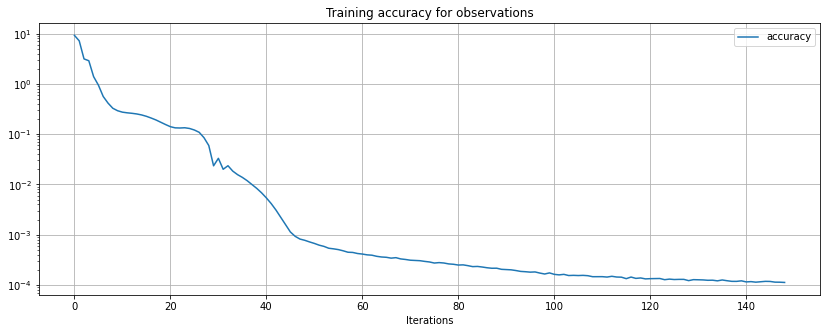

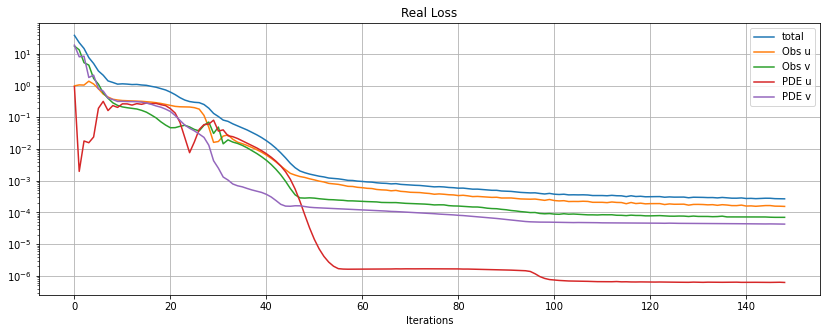

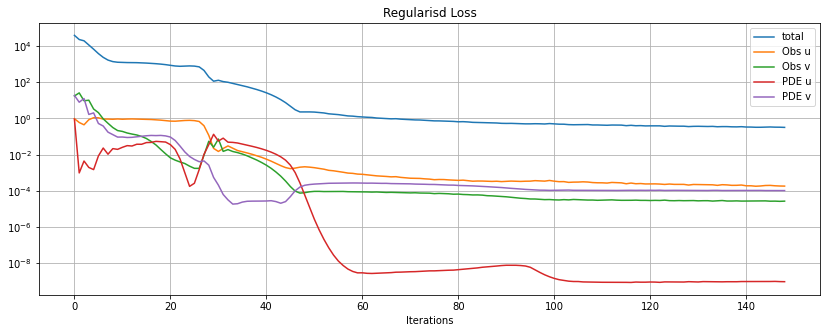

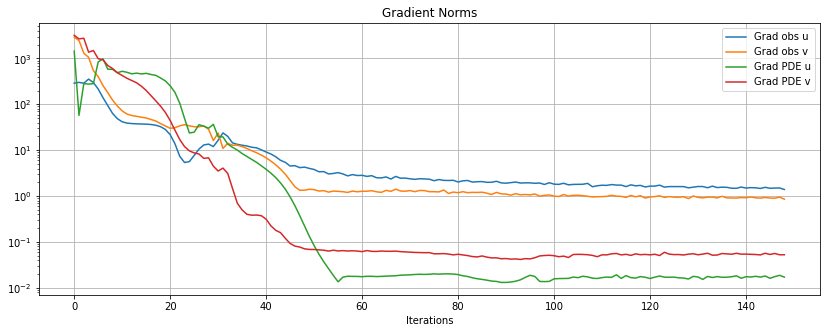

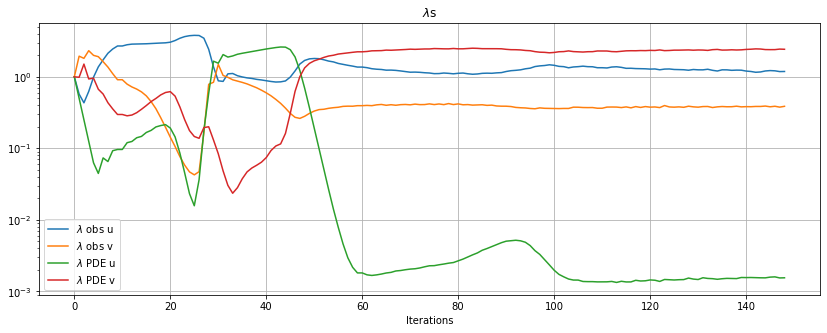

In [112]:
plot_result(merge_dict(results, results2, results3, results4), start = 0)

In [95]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)

T_test_index = 80
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N x 1
YY_test = Y_test.flatten()  # N x 1
TT_test = np.repeat(t_star[T_test_index], N)  # 1 x N

7827.788649706458


In [96]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
u_test = output_test[:, 0].numpy().reshape((x_size, y_size))
v_test = output_test[:, 1].numpy().reshape((x_size, y_size))

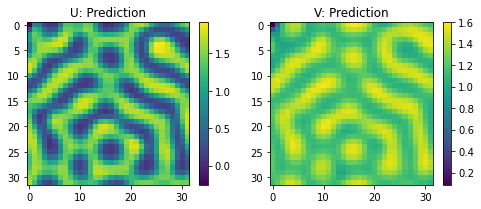

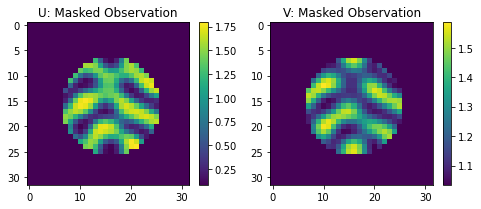

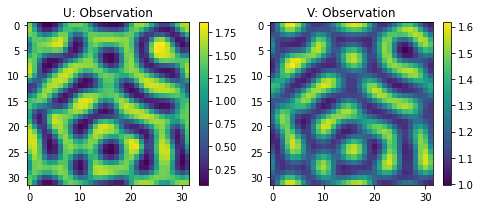

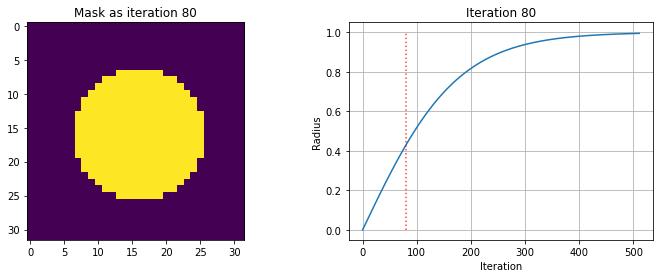

In [109]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("U: Prediction")
plt.imshow(u_test)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.title("V: Prediction")
plt.imshow(v_test)
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("U: Masked Observation")
masked_indices = data_masked[0, :, :, T_test_index] > 0
non_zero_data_masked = data_masked[0, :, :, T_test_index][masked_indices]
plt.imshow(data_masked[0, :, :, T_test_index], 
           vmax=np.max(non_zero_data_masked), 
           vmin=np.min(non_zero_data_masked))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.title("V: Masked Observation")
masked_indices = data_masked[1, :, :, T_test_index] > 0
non_zero_data_masked = data_masked[1, :, :, T_test_index][masked_indices]
plt.imshow(data_masked[1, :, :, T_test_index], 
           vmax=np.max(non_zero_data_masked), 
           vmin=np.min(non_zero_data_masked))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("U: Observation")
plt.imshow(data[0, :, :, T_test_index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.title("V: Observation")
plt.imshow(data[1, :, :, T_test_index])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title(f"Mask as iteration {T_test_index}")
plt.imshow(mask[:, :, T_test_index])
plt.subplot(122)
plt.title(f"Iteration {T_test_index}")
plt.plot(rs)
plt.ylabel("Radius")
plt.xlabel("Iteration")
plt.vlines(T_test_index, 0 , 1, colors='red', linestyles='dotted', alpha=.75)
plt.grid()
plt.show()

In [86]:
def print_vals(name, value, actual=None):
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
        
def print_model(loss, D_a = 0.005, D_s = 0.2):
    sigma_s = loss.sigma_s.numpy()[0]
    rho_s = loss.rho_s.numpy()[0]

    sigma_a = loss.sigma_a.numpy()[0]
    rho_a = loss.rho_a.numpy()[0]
    mu_a = loss.mu_a.numpy()[0]
    kappa_a = loss.kappa_a.numpy()[0]

    print_vals("sigma_s", sigma_s, 0.02)
    print_vals("rho_s", rho_s, 0.02)
    print()    
    print_vals("sigma_a", sigma_a, 0.0)
    print_vals("rho_a", rho_a,0.01)
    print_vals("mu_a", mu_a, 0.01 )
    print_vals("kappa_a", kappa_a, 0.25)

In [87]:
print_model(pde_loss)

sigma_s: 0.01553101, actual: 0.020, difference: 0.00446899, relative: %22.34495738
rho_s: 0.01629042, actual: 0.020, difference: 0.00370958, relative: %18.54791234

sigma_a: 0.00037061, actual: 0.000, difference: 0.00037061 
rho_a: 0.01183161, actual: 0.010, difference: 0.00183161, relative: %18.31608481
mu_a: 0.01151945, actual: 0.010, difference: 0.00151945, relative: %15.19448912
kappa_a: 0.30031792, actual: 0.250, difference: 0.05031792, relative: %20.12716986


In [4]:
layers = [3, 64, 64, 64, 64, 2]
pinn_multi = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss_multi = ASDM(dtype=tf.float64, D_a=.005, D_s = 0.2)
model_multi = TINN_multi_nodes_masked(pinn_multi, 
                pde_loss_multi, 
                alpha = 0.5, 
                print_precision=".8f")

In [5]:
results_multi = model_multi.train(epochs = 250,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 9.28975868
total loss: 38.41203953, total regularisd loss (sum of batches): 39333.92847932
obs node_1 loss: 0.98870150, pde node_1 loss: 1.10378141
obs node_2 loss: 17.59079844, pde node_2 loss: 18.72875818
lambda obs node_1: 1.00000000, lambda pde node_1: 1.00000000
lambda obs node_2: 1.00000000, lambda pde node_2: 1.00000000
sigma_a: 10.00396 sigma_s: 9.16750 mu_a: 9.79603 rho_a: 10.70852 
rho_s: 11.01541 kappa_a: 8.94737 
Time taken: 74.61s

Start of epoch 1
Training observations acc over epoch: 7.18691921
total loss: 22.45657336, total regularisd loss (sum of batches): 22995.53112083
obs node_1 loss: 1.06695838, pde node_1 loss: 0.00186728
obs node_2 loss: 13.30689198, pde node_2 loss: 8.08085572
lambda obs node_1: 0.56828182, lambda pde node_1: 0.50000098
lambda obs node_2: 1.93803055, lambda pde node_2: 0.99368665
sigma_a: 10.01527 sigma_s: 8.36497 mu_a: 9.70417 rho_a: 10.93960 
rho_s: 11.83766 kappa_a: 8.02672 
Time taken: 

Training observations acc over epoch: 0.19046721
total loss: 0.87502053, total regularisd loss (sum of batches): 1082.30504573
obs node_1 loss: 0.29028089, pde node_1 loss: 0.24697487
obs node_2 loss: 0.09065373, pde node_2 loss: 0.24711105
lambda obs node_1: 3.04654447, lambda pde node_1: 0.21230201
lambda obs node_2: 0.29977747, lambda pde node_2: 0.44137605
sigma_a: 4.22088 sigma_s: 1.32724 mu_a: 7.65142 rho_a: 15.90768 
rho_s: 11.45550 kappa_a: 6.63111 
Time taken: 45.46s

Start of epoch 18
Training observations acc over epoch: 0.17082085
total loss: 0.80613355, total regularisd loss (sum of batches): 1032.92579764
obs node_1 loss: 0.27487726, pde node_1 loss: 0.23459342
obs node_2 loss: 0.06676432, pde node_2 loss: 0.22989855
lambda obs node_1: 3.05567400, lambda pde node_1: 0.22821959
lambda obs node_2: 0.22051124, lambda pde node_2: 0.49559518
sigma_a: 3.49978 sigma_s: 1.07860 mu_a: 6.65174 rho_a: 16.98598 
rho_s: 10.31993 kappa_a: 7.33504 
Time taken: 45.93s

Start of epoch 19


Training observations acc over epoch: 0.02119120
total loss: 0.06723981, total regularisd loss (sum of batches): 92.19909412
obs node_1 loss: 0.02495705, pde node_1 loss: 0.02472652
obs node_2 loss: 0.01742533, pde node_2 loss: 0.00013090
lambda obs node_1: 1.14250505, lambda pde node_1: 1.90463539
lambda obs node_2: 0.91010546, lambda pde node_2: 0.04275410
sigma_a: 0.00000 sigma_s: 0.01009 mu_a: 0.64898 rho_a: 13.51601 
rho_s: 0.27917 kappa_a: 19.59360 
Time taken: 46.17s

Start of epoch 35
Training observations acc over epoch: 0.01679692
total loss: 0.05687102, total regularisd loss (sum of batches): 80.97767969
obs node_1 loss: 0.01878181, pde node_1 loss: 0.02317320
obs node_2 loss: 0.01481204, pde node_2 loss: 0.00010398
lambda obs node_1: 1.11524247, lambda pde node_1: 2.03270955
lambda obs node_2: 0.82584631, lambda pde node_2: 0.02620167
sigma_a: 0.00000 sigma_s: 0.00714 mu_a: 0.56677 rho_a: 12.56425 
rho_s: 0.21466 kappa_a: 20.43122 
Time taken: 46.29s

Start of epoch 36
Trai

Training observations acc over epoch: 0.00062546
total loss: 0.00143027, total regularisd loss (sum of batches): 1.87576487
obs node_1 loss: 0.00094553, pde node_1 loss: 0.00002685
obs node_2 loss: 0.00030539, pde node_2 loss: 0.00015251
lambda obs node_1: 1.57620951, lambda pde node_1: 0.25929236
lambda obs node_2: 0.33999060, lambda pde node_2: 1.82450754
sigma_a: 0.00000 sigma_s: 0.00377 mu_a: 0.00642 rho_a: 0.22181 
rho_s: 0.09657 kappa_a: 29.47667 
Time taken: 45.94s

Start of epoch 52
Training observations acc over epoch: 0.00057712
total loss: 0.00131591, total regularisd loss (sum of batches): 1.77555395
obs node_1 loss: 0.00086242, pde node_1 loss: 0.00001252
obs node_2 loss: 0.00029183, pde node_2 loss: 0.00014915
lambda obs node_1: 1.49974779, lambda pde node_1: 0.13472336
lambda obs node_2: 0.35515209, lambda pde node_2: 2.01037676
sigma_a: 0.00000 sigma_s: 0.00462 mu_a: 0.00383 rho_a: 0.13710 
rho_s: 0.11360 kappa_a: 29.46415 
Time taken: 46.38s

Start of epoch 53
Training

Training observations acc over epoch: 0.00028759
total loss: 0.00068723, total regularisd loss (sum of batches): 0.73541696
obs node_1 loss: 0.00037021, pde node_1 loss: 0.00000154
obs node_2 loss: 0.00020497, pde node_2 loss: 0.00011051
lambda obs node_1: 0.89511297, lambda pde node_1: 0.00130674
lambda obs node_2: 0.43579885, lambda pde node_2: 2.66778143
sigma_a: 0.00000 sigma_s: 0.02549 mu_a: 0.00000 rho_a: 0.00117 
rho_s: 0.47498 kappa_a: 19.65296 
Time taken: 46.00s

Start of epoch 69
Training observations acc over epoch: 0.00028619
total loss: 0.00068232, total regularisd loss (sum of batches): 0.72460783
obs node_1 loss: 0.00036791, pde node_1 loss: 0.00000154
obs node_2 loss: 0.00020446, pde node_2 loss: 0.00010840
lambda obs node_1: 0.88010216, lambda pde node_1: 0.00135480
lambda obs node_2: 0.43295309, lambda pde node_2: 2.68558995
sigma_a: 0.00000 sigma_s: 0.02609 mu_a: 0.00000 rho_a: 0.00091 
rho_s: 0.46846 kappa_a: 18.88880 
Time taken: 46.04s

Start of epoch 70
Training

Training observations acc over epoch: 0.00019757
total loss: 0.00047427, total regularisd loss (sum of batches): 0.49265323
obs node_1 loss: 0.00024792, pde node_1 loss: 0.00000155
obs node_2 loss: 0.00014722, pde node_2 loss: 0.00007758
lambda obs node_1: 0.81689373, lambda pde node_1: 0.00265991
lambda obs node_2: 0.44477698, lambda pde node_2: 2.73566939
sigma_a: 0.00000 sigma_s: 0.02898 mu_a: 0.00000 rho_a: 0.00189 
rho_s: 0.22561 kappa_a: 7.07758 
Time taken: 45.98s

Start of epoch 86
Training observations acc over epoch: 0.00019644
total loss: 0.00047009, total regularisd loss (sum of batches): 0.48556123
obs node_1 loss: 0.00024842, pde node_1 loss: 0.00000154
obs node_2 loss: 0.00014446, pde node_2 loss: 0.00007566
lambda obs node_1: 0.84457544, lambda pde node_1: 0.00277347
lambda obs node_2: 0.43407215, lambda pde node_2: 2.71857895
sigma_a: 0.00000 sigma_s: 0.02927 mu_a: 0.00000 rho_a: 0.00150 
rho_s: 0.20339 kappa_a: 6.36972 
Time taken: 46.23s

Start of epoch 87
Training o

Training observations acc over epoch: 0.00014383
total loss: 0.00034246, total regularisd loss (sum of batches): 0.39823969
obs node_1 loss: 0.00019960, pde node_1 loss: 0.00000069
obs node_2 loss: 0.00008806, pde node_2 loss: 0.00005412
lambda obs node_1: 1.09449032, lambda pde node_1: 0.00155988
lambda obs node_2: 0.37484183, lambda pde node_2: 2.52910797
sigma_a: 0.00000 sigma_s: 0.01714 mu_a: 0.01039 rho_a: 0.01225 
rho_s: 0.02051 kappa_a: 0.38497 
Time taken: 46.13s

Start of epoch 103
Training observations acc over epoch: 0.00014412
total loss: 0.00034307, total regularisd loss (sum of batches): 0.39928050
obs node_1 loss: 0.00020134, pde node_1 loss: 0.00000067
obs node_2 loss: 0.00008689, pde node_2 loss: 0.00005416
lambda obs node_1: 1.11748763, lambda pde node_1: 0.00149614
lambda obs node_2: 0.37632082, lambda pde node_2: 2.50469541
sigma_a: 0.00000 sigma_s: 0.01773 mu_a: 0.01034 rho_a: 0.01212 
rho_s: 0.01986 kappa_a: 0.38028 
Time taken: 46.05s

Start of epoch 104
Training

Training observations acc over epoch: 0.00012509
total loss: 0.00030287, total regularisd loss (sum of batches): 0.34056638
obs node_1 loss: 0.00016734, pde node_1 loss: 0.00000061
obs node_2 loss: 0.00008285, pde node_2 loss: 0.00005207
lambda obs node_1: 0.97743289, lambda pde node_1: 0.00135085
lambda obs node_2: 0.39651309, lambda pde node_2: 2.62470317
sigma_a: 0.00000 sigma_s: 0.01696 mu_a: 0.01029 rho_a: 0.01124 
rho_s: 0.01886 kappa_a: 0.32432 
Time taken: 46.41s

Start of epoch 120
Training observations acc over epoch: 0.00012267
total loss: 0.00029839, total regularisd loss (sum of batches): 0.33869464
obs node_1 loss: 0.00016494, pde node_1 loss: 0.00000061
obs node_2 loss: 0.00008039, pde node_2 loss: 0.00005245
lambda obs node_1: 0.95857258, lambda pde node_1: 0.00133273
lambda obs node_2: 0.38222760, lambda pde node_2: 2.65786709
sigma_a: 0.00000 sigma_s: 0.01666 mu_a: 0.01014 rho_a: 0.01103 
rho_s: 0.01816 kappa_a: 0.32244 
Time taken: 46.07s

Start of epoch 121
Training

Training observations acc over epoch: 0.00011552
total loss: 0.00028235, total regularisd loss (sum of batches): 0.31669426
obs node_1 loss: 0.00015378, pde node_1 loss: 0.00000059
obs node_2 loss: 0.00007726, pde node_2 loss: 0.00005071
lambda obs node_1: 0.91914606, lambda pde node_1: 0.00140107
lambda obs node_2: 0.39088274, lambda pde node_2: 2.68857013
sigma_a: 0.00000 sigma_s: 0.01724 mu_a: 0.00999 rho_a: 0.01050 
rho_s: 0.01775 kappa_a: 0.30068 
Time taken: 46.31s

Start of epoch 137
Training observations acc over epoch: 0.00011696
total loss: 0.00028495, total regularisd loss (sum of batches): 0.31669116
obs node_1 loss: 0.00015566, pde node_1 loss: 0.00000059
obs node_2 loss: 0.00007827, pde node_2 loss: 0.00005044
lambda obs node_1: 0.94003063, lambda pde node_1: 0.00143713
lambda obs node_2: 0.40442609, lambda pde node_2: 2.65410614
sigma_a: 0.00000 sigma_s: 0.01691 mu_a: 0.00994 rho_a: 0.01066 
rho_s: 0.01772 kappa_a: 0.30064 
Time taken: 46.21s

Start of epoch 138
Training

Training observations acc over epoch: 0.00010619
total loss: 0.00026198, total regularisd loss (sum of batches): 0.29029386
obs node_1 loss: 0.00013856, pde node_1 loss: 0.00000059
obs node_2 loss: 0.00007382, pde node_2 loss: 0.00004901
lambda obs node_1: 0.85398362, lambda pde node_1: 0.00144169
lambda obs node_2: 0.39132271, lambda pde node_2: 2.75325199
sigma_a: 0.00000 sigma_s: 0.01638 mu_a: 0.00960 rho_a: 0.01038 
rho_s: 0.01772 kappa_a: 0.28767 
Time taken: 46.13s

Start of epoch 154
Training observations acc over epoch: 0.00010853
total loss: 0.00026617, total regularisd loss (sum of batches): 0.29090874
obs node_1 loss: 0.00014164, pde node_1 loss: 0.00000058
obs node_2 loss: 0.00007542, pde node_2 loss: 0.00004853
lambda obs node_1: 0.88479256, lambda pde node_1: 0.00149390
lambda obs node_2: 0.40707438, lambda pde node_2: 2.70663917
sigma_a: 0.00000 sigma_s: 0.01736 mu_a: 0.00984 rho_a: 0.01018 
rho_s: 0.01734 kappa_a: 0.28764 
Time taken: 46.11s

Start of epoch 155
Training

Training observations acc over epoch: 0.00010003
total loss: 0.00024712, total regularisd loss (sum of batches): 0.27563889
obs node_1 loss: 0.00013098, pde node_1 loss: 0.00000060
obs node_2 loss: 0.00006908, pde node_2 loss: 0.00004646
lambda obs node_1: 0.88446068, lambda pde node_1: 0.00163147
lambda obs node_2: 0.40433222, lambda pde node_2: 2.70957563
sigma_a: 0.00000 sigma_s: 0.01697 mu_a: 0.00956 rho_a: 0.00982 
rho_s: 0.01769 kappa_a: 0.26667 
Time taken: 46.11s

Start of epoch 171
Training observations acc over epoch: 0.00009976
total loss: 0.00024621, total regularisd loss (sum of batches): 0.27477604
obs node_1 loss: 0.00013067, pde node_1 loss: 0.00000060
obs node_2 loss: 0.00006884, pde node_2 loss: 0.00004611
lambda obs node_1: 0.86625997, lambda pde node_1: 0.00159757
lambda obs node_2: 0.40093942, lambda pde node_2: 2.73120304
sigma_a: 0.00000 sigma_s: 0.01674 mu_a: 0.00948 rho_a: 0.00956 
rho_s: 0.01720 kappa_a: 0.26545 
Time taken: 46.08s

Start of epoch 172
Training

Training observations acc over epoch: 0.00009440
total loss: 0.00023115, total regularisd loss (sum of batches): 0.25654409
obs node_1 loss: 0.00012304, pde node_1 loss: 0.00000064
obs node_2 loss: 0.00006576, pde node_2 loss: 0.00004171
lambda obs node_1: 0.91918275, lambda pde node_1: 0.00194723
lambda obs node_2: 0.41122195, lambda pde node_2: 2.66764807
sigma_a: 0.00000 sigma_s: 0.01605 mu_a: 0.00965 rho_a: 0.00951 
rho_s: 0.01670 kappa_a: 0.26566 
Time taken: 45.81s

Start of epoch 188
Training observations acc over epoch: 0.00008956
total loss: 0.00022125, total regularisd loss (sum of batches): 0.24895231
obs node_1 loss: 0.00011571, pde node_1 loss: 0.00000064
obs node_2 loss: 0.00006341, pde node_2 loss: 0.00004149
lambda obs node_1: 0.90535840, lambda pde node_1: 0.00194885
lambda obs node_2: 0.41522906, lambda pde node_2: 2.67746369
sigma_a: 0.00000 sigma_s: 0.01590 mu_a: 0.00950 rho_a: 0.00978 
rho_s: 0.01643 kappa_a: 0.26675 
Time taken: 45.94s

Start of epoch 189
Training

Training observations acc over epoch: 0.00008841
total loss: 0.00021422, total regularisd loss (sum of batches): 0.24857946
obs node_1 loss: 0.00011884, pde node_1 loss: 0.00000067
obs node_2 loss: 0.00005798, pde node_2 loss: 0.00003672
lambda obs node_1: 1.06378978, lambda pde node_1: 0.00267416
lambda obs node_2: 0.42896789, lambda pde node_2: 2.50456817
sigma_a: 0.00000 sigma_s: 0.01576 mu_a: 0.00950 rho_a: 0.00958 
rho_s: 0.01564 kappa_a: 0.27106 
Time taken: 46.32s

Start of epoch 205
Training observations acc over epoch: 0.00008463
total loss: 0.00020631, total regularisd loss (sum of batches): 0.24078918
obs node_1 loss: 0.00011252, pde node_1 loss: 0.00000068
obs node_2 loss: 0.00005674, pde node_2 loss: 0.00003638
lambda obs node_1: 1.05386872, lambda pde node_1: 0.00269797
lambda obs node_2: 0.42760780, lambda pde node_2: 2.51582550
sigma_a: 0.00000 sigma_s: 0.01574 mu_a: 0.00957 rho_a: 0.00967 
rho_s: 0.01576 kappa_a: 0.27121 
Time taken: 46.58s

Start of epoch 206
Training

Training observations acc over epoch: 0.00008141
total loss: 0.00019608, total regularisd loss (sum of batches): 0.23031141
obs node_1 loss: 0.00010956, pde node_1 loss: 0.00000070
obs node_2 loss: 0.00005325, pde node_2 loss: 0.00003257
lambda obs node_1: 1.09977939, lambda pde node_1: 0.00311658
lambda obs node_2: 0.42469885, lambda pde node_2: 2.47240517
sigma_a: 0.00000 sigma_s: 0.01554 mu_a: 0.00968 rho_a: 0.00997 
rho_s: 0.01566 kappa_a: 0.27454 
Time taken: 46.76s

Start of epoch 222
Training observations acc over epoch: 0.00008107
total loss: 0.00019511, total regularisd loss (sum of batches): 0.22700182
obs node_1 loss: 0.00010816, pde node_1 loss: 0.00000070
obs node_2 loss: 0.00005398, pde node_2 loss: 0.00003228
lambda obs node_1: 1.12515556, lambda pde node_1: 0.00326052
lambda obs node_2: 0.44476350, lambda pde node_2: 2.42682042
sigma_a: 0.00000 sigma_s: 0.01534 mu_a: 0.00978 rho_a: 0.00990 
rho_s: 0.01518 kappa_a: 0.27745 
Time taken: 46.35s

Start of epoch 223
Training

Training observations acc over epoch: 0.00008081
total loss: 0.00019205, total regularisd loss (sum of batches): 0.22601802
obs node_1 loss: 0.00011004, pde node_1 loss: 0.00000071
obs node_2 loss: 0.00005158, pde node_2 loss: 0.00002972
lambda obs node_1: 1.17828973, lambda pde node_1: 0.00353272
lambda obs node_2: 0.43089394, lambda pde node_2: 2.38728361
sigma_a: 0.00000 sigma_s: 0.01510 mu_a: 0.00957 rho_a: 0.01030 
rho_s: 0.01529 kappa_a: 0.28366 
Time taken: 46.46s

Start of epoch 239
Training observations acc over epoch: 0.00007794
total loss: 0.00018618, total regularisd loss (sum of batches): 0.22189672
obs node_1 loss: 0.00010553, pde node_1 loss: 0.00000070
obs node_2 loss: 0.00005036, pde node_2 loss: 0.00002959
lambda obs node_1: 1.16528436, lambda pde node_1: 0.00377678
lambda obs node_2: 0.43306373, lambda pde node_2: 2.39787513
sigma_a: 0.00000 sigma_s: 0.01437 mu_a: 0.00992 rho_a: 0.01014 
rho_s: 0.01542 kappa_a: 0.28563 
Time taken: 46.60s

Start of epoch 240
Training

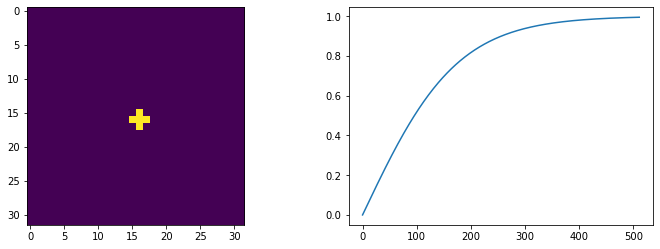

In [6]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

mask = np.zeros_like(data[0, : , :, :], dtype=np.float64)
x_center = x_size//2
y_center = y_size//2


x_mask_domain = np.arange(0, x_size, 1, dtype=np.int32)
y_mask_domain = np.arange(0, x_size, 1, dtype=np.int32)

X_mask, Y_mask = np.meshgrid(x_mask_domain, y_mask_domain, sparse=False, indexing="ij")
radius = np.sqrt( (X_mask-x_center)**2 + (Y_mask-y_center)**2 )
# normalised
radius = radius/np.sqrt( x_center**2 + y_center**2 )


time_scale = 0.06/T
rs = np.zeros_like(t_star)
for i, t in enumerate(t_star):
    r = 2.0/(1+np.exp(-time_scale*t))-1.0
    rs[i] = r
    mask[:, :, i] = radius < r

    
_ = plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(mask[:, :, 10])
plt.subplot(122)
plt.plot(rs)

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

data_masked = data.copy()
data_masked = data*mask

dataset = create_dataset_mask(data_masked, mask, t_star, N, T, L, shuffle=False, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']
obs_mask = dataset['obs_mask']